In [1]:
import os
import sys

import numpy as np
import mongo
import pickle
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from dogss.data import collate_pool, MergeDataset
from dogss.dogss import DOGSS

import skorch
from skorch.dataset import CVSplit
from sklearn.model_selection import ShuffleSplit, train_test_split
from skorch import NeuralNetRegressor
from skorch.callbacks import Checkpoint #needs skorch 0.4.0, conda-forge version at 0.3.0 doesn't cut it
from skorch.callbacks.lr_scheduler import LRScheduler

from utils.adamwr.adamw import AdamW


/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
SDT_list_path = 'path/to/dataset'
docs_path = 'path/to/dataset'

In [3]:
SDT_list = pickle.load(open(SDT_list_path , 'rb'))
docs = pickle.load(open(docs_path, 'rb'))
target_list = np.array([sdt[-1][sdt[-2]].numpy() for sdt in SDT_list]).reshape(-1,1) #get final_pos of free atoms ONLY


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
structures = SDT_list[0]
orig_node_fea_size = structures[0].shape[-1]
edge_fea_size = structures[1].shape[-1]

In [5]:
SDT_training, SDT_test, target_training, target_test, docs_training, docs_test \
= train_test_split(SDT_list, target_list, docs, test_size=0.1, random_state=42)

In [6]:
cuda = torch.cuda.is_available()
if cuda:
    device = torch.device("cuda")
else:
    device='cpu'

#Make a checkpoint to save parameters every time there is a new best for validation lost
cp = Checkpoint(monitor='valid_loss_best',fn_prefix='valid_best_')

#Callback to load the checkpoint with the best validation loss at the end of training

class train_end_load_best_valid_loss(skorch.callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params('valid_best_params.pt')
        
load_best_valid_loss = train_end_load_best_valid_loss()
print('device:', device)

device: cuda


In [7]:
natoms = []
num_elements = []
symbols = []
for doc in docs_training:
    natoms.append(doc['atoms']['natoms'])
    num_elements.append(len(doc['atoms']['chemical_symbols']))
    symbols.extend(doc['atoms']['chemical_symbols'])
num_symbols = len(set(symbols))
print(num_symbols)

33


In [8]:
natoms_test = []
num_elements_test = []
symbols_test = []
for doc in docs_test:
    natoms_test.append(doc['atoms']['natoms'])
    num_elements_test.append(len(doc['atoms']['chemical_symbols']))
    symbols_test.extend(doc['atoms']['chemical_symbols'])
num_symbols_test = len(set(symbols_test))
print(num_symbols_test)

33


In [9]:
set(symbols_test) ^ set(symbols)

set()

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'H adsorption')

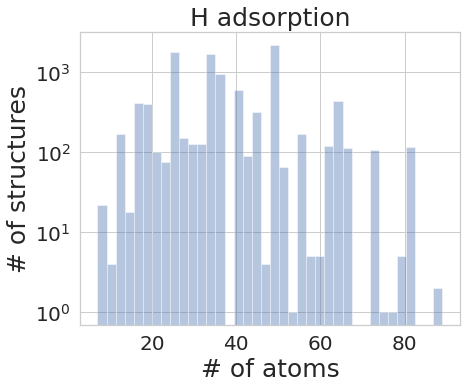

In [10]:
import pandas as pd

sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(6.8, 5.4)})
sns.set(font_scale = 1.6)
sns.set_style("whitegrid")
# sns.set_style("white")

df = pd.DataFrame(np.array([natoms, num_elements]).T, columns=["natoms", "num_elements"])
ax = sns.distplot(df["natoms"], kde=False)
ax.set_yscale('log')
ax.set_ylabel('# of structures',  fontsize=25)
ax.set_xlabel('# of atoms',  fontsize=25)
ax.tick_params(labelsize=20)
ax.set_title('H adsorption', fontsize=25)
# plt.savefig('./num_atoms.pdf', bbox_inches = 'tight')

Text(0.5, 1.0, 'H adsorption')

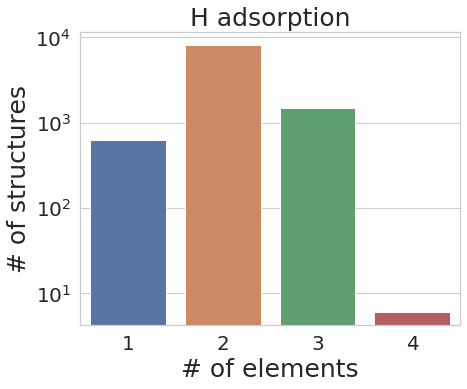

In [11]:
from collections import Counter
sns.set_style("whitegrid")

elements = pd.DataFrame.from_dict(Counter(num_elements), orient='index', columns=["# of structures"]).reset_index()
elements["index"] = elements["index"]-1

ax2 = sns.barplot(x='index', y='# of structures', data=elements)
ax2.set_yscale('log')
ax2.set_ylabel('# of structures',  fontsize=25)
ax2.set_xlabel('# of elements',  fontsize=25)
ax2.tick_params(labelsize=20)
ax2.set_title('H adsorption', fontsize=25)
# plt.savefig('./num_elements_H.pdf', bbox_inches = 'tight')

In [12]:
train_test_splitter = ShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

batchsize = 18

LR_schedule = LRScheduler("MultiStepLR", milestones=[100], gamma=0.1)

class NewDOGSS(NeuralNetRegressor):
    def get_loss(self, y_pred, y_true, **kwargs):
        y_pred = y_pred[0] if isinstance(y_pred, tuple) else y_pred  # discard the 2nd output
        differ=torch.sum((y_pred-y_true.cuda())**2.0,dim=1)
        if torch.nonzero(differ).shape[0] != differ.shape[0]:
            print('zero sqrt for Loss')
        differ = torch.clamp(differ, min=1e-8)
        return torch.mean(torch.sqrt(differ))


net = NewDOGSS(
    DOGSS,
    batch_size=batchsize, #214
    module__orig_node_fea_size = orig_node_fea_size,
    module__edge_fea_size = edge_fea_size,
    lr=0.0037704604911552916,
    max_epochs= 200,
    module__energy_mode="Harmonic", #["Harmonic", "Morse", "LJ"], Default = "Harmonic"
    module__node_fea_size=103, #46,
    module__h_fea_len=169,
    module__h_fea_len_dist=18,
    module__h_fea_len_const=18,
    module__h_fea_len_D=18,
    module__n_conv=12, #8
    module__n_h_dist=16,
    module__n_h_const=0,
    module__n_h_D= 12,
    module__min_opt_steps=30,
    module__max_opt_steps=150,
    module__momentum=0.8,
    optimizer=AdamW,
    optimizer__weight_decay=0.000045399929762484854,
    iterator_train__pin_memory=True,
    iterator_train__num_workers=0,
    iterator_train__shuffle=True,
    iterator_train__collate_fn = collate_pool,
    iterator_valid__pin_memory=True,
    iterator_valid__num_workers=0,
    iterator_valid__collate_fn = collate_pool,
    device=device,
    criterion=torch.nn.L1Loss,
    dataset=MergeDataset,
    train_split = CVSplit(cv=train_test_splitter),
    callbacks=[cp,LR_schedule , load_best_valid_loss],
)

In [13]:
## Loading pre-trained DOGSS
net.initialize()
net.load_params(f_history = './valid_best_history.json',
               f_optimizer = './valid_best_optimizer.pt',
               f_params = './valid_best_params.pt')

In [14]:
def get_targets(dummy_SDT, dummy_targets):
    targets = []
    for i, target in enumerate(dummy_targets):
        free_atom_idx = dummy_SDT[i][-2]
        targets.append(target[0].reshape(-1,3))
        assert len(free_atom_idx) == len(target[0])
    return np.concatenate(targets)

def get_distance(pred, true):
    diff = np.sum((pred - true)**2, axis=1)
    return np.sqrt(diff)

def get_initial(dummy_SDT):
    init_test = []
    for sdt in dummy_SDT:
        free_atom_idx = sdt[-2]
        atom_pos = sdt[4][free_atom_idx]
        init_test.append(atom_pos)
    return np.concatenate(init_test)

In [15]:
init_test = get_initial(SDT_test)
pred_test = net.predict(SDT_test)
true_test = get_targets(SDT_test, target_test)

distance_test = get_distance(pred_test, true_test)
distance_pred_initial = get_distance(pred_test, init_test)
distance_init = get_distance(init_test, true_test)

torch.cuda.empty_cache()

In [16]:
def analysis(SDT, docs, distance, distance_pred_initial, distance_init):
    total_atoms = 0
    MAE_ads, MAE_ads_init = [],[]
    MAE_non_ads, MAE_non_ads_init= [], []
    
    for i in range(len(SDT)):
        doc = docs[i]
        sdt = SDT[i]
        ads_idx_base = sdt[-4]
        ads_tag = np.where(ads_idx_base == 1)[0]
        num_atoms = sdt[-2].shape[0]
        free_atom_idx = sdt[-2]
        ads_idx = np.where(free_atom_idx == int(ads_tag))[0]
        
        non_ads_free_base = np.arange(len(free_atom_idx))
        non_ads_idx = np.where(non_ads_free_base != ads_idx)[0]
        dist = distance[total_atoms: total_atoms+num_atoms]
        dist_init = distance_init[total_atoms: total_atoms+num_atoms]
        total_atoms += num_atoms

        atoms = mongo.make_atoms_from_doc(doc, is_initial=True)
        atoms_final = mongo.make_atoms_from_doc(doc, is_initial=False)

        MAE_non_ads.append(dist[non_ads_idx])
        MAE_non_ads_init.append(dist_init[non_ads_idx])
        MAE_ads_init.append(dist_init[ads_idx])
        MAE_ads.append(dist[ads_idx])
            
    return np.concatenate(MAE_ads_init), np.concatenate(MAE_ads), np.concatenate(MAE_non_ads_init), np.concatenate(MAE_non_ads)

In [17]:
###### Per Structure MAE ##### (NOT Per Atom MAE)
MAE_ads_init, MAE_ads, MAE_non_ads_init, MAE_non_ads\
= analysis(SDT_test, docs_test, distance_test, distance_pred_initial, distance_init)

In [18]:
print(np.mean(MAE_ads), np.mean(MAE_ads_init), np.mean(MAE_ads)/np.mean(MAE_ads_init))
print(np.mean(MAE_non_ads), np.mean(MAE_non_ads_init), np.mean(MAE_non_ads)/np.mean(MAE_non_ads_init))

0.34087938 0.78409564 0.4347421
0.051539145 0.08547573 0.6029682


/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


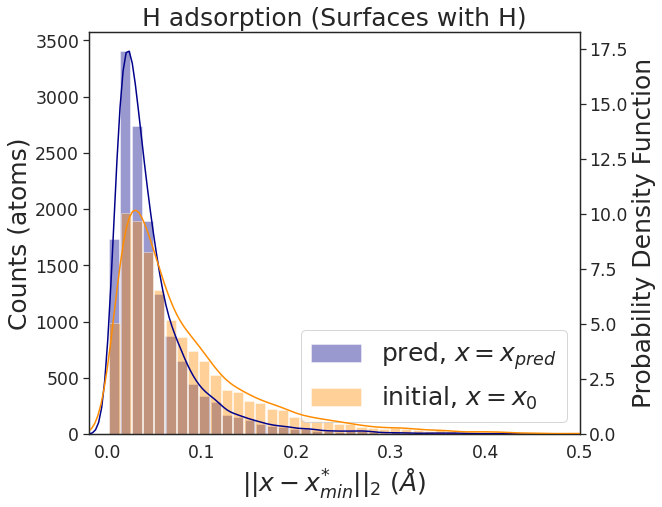

In [20]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(8.8, 7.4)})
sns.set(font_scale = 1.2)
sns.set_style("white")

idx = np.where(MAE_non_ads < 0.6)[0]
idx_init = np.where(MAE_non_ads_init < 0.6)[0]

ax = sns.distplot(MAE_non_ads[idx], bins=50, kde=False, norm_hist=False, color='darkblue', label='pred, $x = x_{pred}$'
                 ,hist_kws={"rwidth":0.9})
ax = sns.distplot(MAE_non_ads_init[idx_init], bins=50, kde=False,norm_hist=False, color='darkorange', label='initial, $x = x_{0}$'
                 ,hist_kws={"rwidth":0.9})


_ = ax.set_xlim(-0.02, 0.5)
_ = ax.set_xlabel('$\||x - x^{*}_{min}\||_{2}$ ($\AA$)', fontsize=25)
_ = ax.set_ylabel('Counts (atoms)', fontsize=25)
_ = ax.set_title('H adsorption (Surfaces with H)', fontsize=25)
_ = ax.tick_params(labelsize='large')

_ = ax.legend(loc='lower right', fontsize=25)
ax2 = ax.twinx()
ax2 = sns.kdeplot(MAE_non_ads[idx], color='darkblue')
ax2 = sns.kdeplot(MAE_non_ads_init[idx_init], color='darkorange')
_ = ax2.set_ylabel('Probability Density Function', fontsize=25)
_ = ax2.tick_params(labelsize='large')

# plt.savefig('./plot_H.pdf', bbox_inches = 'tight')

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


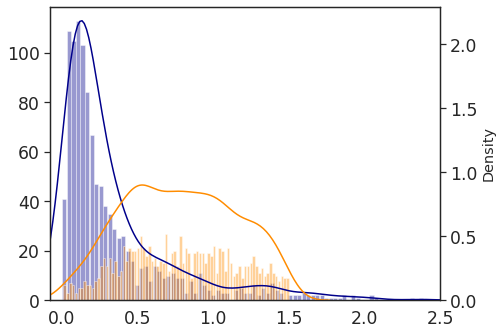

In [21]:
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(7, 5.4)})
sns.set(font_scale = 1.2)
sns.set_style("white")

ax = sns.distplot(MAE_ads, bins=80, kde=False, norm_hist=False, color='darkblue', label='pred, $x = \hat{x}_{min}$'
                 ,hist_kws={"rwidth":0.9})
ax = sns.distplot(MAE_ads_init, bins=80, kde=False,norm_hist=False, color='darkorange', label='initial, $x = x_{0}$'
                 ,hist_kws={"rwidth":0.9})

_ = ax.set_xlim(-0.08, 2.5)
_ = ax.tick_params(labelsize='large')

ax2 = ax.twinx()
ax2 = sns.kdeplot(MAE_ads, color='darkblue')
ax2 = sns.kdeplot(MAE_ads_init, color='darkorange')
_ = ax2.tick_params(labelsize='large')

# plt.savefig('./plot_H_ads.pdf')